# Creating plots to illustrate cell fate (fig1)

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import btrack
import napari
import numpy as np
from tqdm.auto import tqdm
from macrohet import dataio, tile, tools, visualise
import seaborn as sns
import math
from skimage.transform import rescale
from skimage.util import img_as_uint


# def calc_eccentricity(major_axis, minor_axis):
#     """
#     Calculates the eccentricity of an object given its major and minor axis
#     lengths
#     """
#     if major_axis < minor_axis:
#         major_axis, minor_axis = minor_axis, major_axis # swap if major axis is smaller
#     eccentricity = math.sqrt(1 - (minor_axis**2 / major_axis**2))
#     return eccentricity

# scale_factor = 6048/1200

# def highlight_cell(cell_ID, viewer = viewer, tracks = tracks,
#                    scale_factor = 6048/1200):
#     track = [track for track in tracks if track.ID == cell_ID][0]
#     points = [[track.t[i], track.y[i]*scale_factor, track.x[i]*scale_factor]
#                for i in range(len(track))]
#     viewer.add_points(points, size = 300,
#                       face_color = 'transparent',
#                       edge_color = 'white',
#                       edge_width = 0.1,
#                       name = f'cell {cell_ID}', scale = napari_scale)
#     viewer.dims.current_step = (points[0])
    
# def count_values(dictionary):
#     # create an empty dictionary to store the frequency of values
#     frequency_dict = {}
#     # iterate over the values in the input dictionary
#     for value in dictionary.values():
#         # if the value is not in the frequency dictionary, add it with a count of 1
#         if value not in frequency_dict:
#             frequency_dict[value] = 1
#         # if the value is already in the frequency dictionary, increment its count
#         else:
#             frequency_dict[value] += 1
#     # return the frequency dictionary
#     return frequency_dict

## Load data

Begin with experiment metadata then use that information to load all tracks for each assay


In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
image_metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = dataio.read_harmony_metadata(image_metadata_fn)
assay_layout_metadata = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = dataio.read_harmony_metadata(assay_layout_metadata, assay_layout=True)
assay_layout

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

## Load tracks

In [4]:
tracks_dict = dict()
segmentation_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    ### load tracks
    with btrack.dataio.HDF5FileHandler(
            f'/mnt/DATA/macrohet/labels/full_localisation/({row},{column}).h5',#
            'r', 
            obj_type = 'obj_type_1', 
            ) as hdf: 
            tracks = hdf.tracks
            seg = hdf.segmentation
            
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg


Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/04/06 11:22:04 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,4).h5...
[INFO][2023/04/06 11:22:04 AM] Loading tracks/obj_type_1
[INFO][2023/04/06 11:22:04 AM] Loading LBEP/obj_type_1
[INFO][2023/04/06 11:22:04 AM] Loading objects/obj_type_1 (25554, 5) (25554 filtered: None)
[INFO][2023/04/06 11:22:05 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/04/06 11:22:05 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,4).h5
[INFO][2023/04/06 11:22:05 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,5).h5...
[INFO][2023/04/06 11:22:05 AM] Loading tracks/obj_type_1
[INFO][2023/04/06 11:22:05 AM] Loading LBEP/obj_type_1
[INFO][2023/04/06 11:22:05 AM] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/04/06 11:22:06 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/04/06 11:22:06 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,5).h5
[INFO][2023/04/06 11:22:06 AM] Opening H

[INFO][2023/04/06 11:22:22 AM] Loading tracks/obj_type_1
[INFO][2023/04/06 11:22:22 AM] Loading LBEP/obj_type_1
[INFO][2023/04/06 11:22:22 AM] Loading objects/obj_type_1 (22122, 5) (22122 filtered: None)
[INFO][2023/04/06 11:22:23 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/04/06 11:22:23 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(5,9).h5
[INFO][2023/04/06 11:22:23 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,4).h5...
[INFO][2023/04/06 11:22:23 AM] Loading tracks/obj_type_1
[INFO][2023/04/06 11:22:23 AM] Loading LBEP/obj_type_1
[INFO][2023/04/06 11:22:23 AM] Loading objects/obj_type_1 (24744, 5) (24744 filtered: None)
[INFO][2023/04/06 11:22:24 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/04/06 11:22:24 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,4).h5
[INFO][2023/04/06 11:22:24 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,5).h5...
[INFO][2023/04/06 11:22:24 AM] Loading t

## Isolate two experiments

In [5]:
RD1_tracks = tracks_dict[(3,4)]
CTRL_tracks = tracks_dict[(3,5)]

### Get masks

In [16]:
masks_stack = segmentation_dict[(3,5)]
masks_stack_resized = list()
for t in tqdm(range(len(masks_stack)), 
                  desc = f'Resizing masks', leave = False):
    ### resize mask to be 1200 pixels squared
    mask_resized = rescale(masks_stack[t], 6048/1200, anti_aliasing=False)
    
    mask_resized = img_as_uint(mask_resized)
    
    masks_stack_resized.append(mask_resized.astype(np.uint16))
masks_stack_resized = np.stack(masks_stack_resized, axis = 0)

Resizing masks:   0%|          | 0/75 [00:00<?, ?it/s]

# View tracks


In [20]:
row, column = (3,5)
images = tile.compile_mosaic(
                             image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane = 'sum_proj',
                             ).astype(np.uint16)

In [21]:
images

,Array,Chunk
Bytes,10.22 GiB,15.50 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,16875 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [22]:
%%time
images = images.compute().compute()

CPU times: user 3h 42min 9s, sys: 8min 4s, total: 3h 50min 13s
Wall time: 8min 16s


# Fixing upscale procedure

In [25]:
v = napari.Viewer()

v.add_labels(masks_stack_resized)
v.add_labels(masks_stack)

v.add_image(images, 
                 channel_axis = 1, 
                 colormap= ['green', 'magenta'], 
                 contrast_limits= [[0,6000], [0, 2000]],
                 blending = ['translucent', 'additive'],
#                  scale = napari_scale, 
#                 visible=False
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'Image' at 0x7fc2bf7776d0>,
 <Image layer 'Image [1]' at 0x7fc2bb796a60>]

In [26]:
from skimage.io import imsave

In [28]:
imsave('../test_gfp.tif', images[0,0,...])

### Filter some tracks

In [23]:
filt_CTRL_tracks = [track for track in CTRL_tracks if len(track) > 74]
semi_filt_CTRL_tracks = [track for track in CTRL_tracks if 74>len(track) > 34]

In [37]:
filt_tracks, properties, graph = btrack.utils.tracks_to_napari(filt_CTRL_tracks, ndim = 2)
filt_tracks = tools.scale_napari_tracks(filt_tracks)
semi_filt_tracks, properties, graph = btrack.utils.tracks_to_napari(semi_filt_CTRL_tracks, ndim = 2)
semi_filt_tracks = tools.scale_napari_tracks(semi_filt_tracks)
#tracks = scale_napari_tracks(tracks)


In [169]:
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
napari_tracks = tools.scale_napari_tracks(napari_tracks)

In [34]:
import seaborn as sns

(0.0, 200.0)

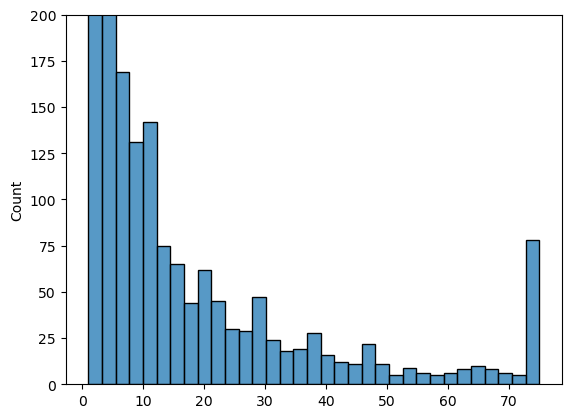

In [36]:
# what do the distribution of track lengths look like?
sns.histplot([len(track) for track in CTRL_tracks])
plt.ylim(0,200)

In [171]:
napari_scale = [float('%.5g' % float(metadata.ImageResolutionX[0])), 
                float('%.5g' % float(metadata.ImageResolutionY[0]))]
### add exaggerated time scale
napari_scale = [1.49E-5, 1.4949e-07, 1.4949e-07]

In [728]:
viewer = napari.Viewer()
# viewer.theme = 'dark'

# viewer.add_tracks(filt_tracks, name = 'FILTERED tracks', 
#                   blending='additive', scale = napari_scale)
# viewer.add_tracks(filt_tracks, name = 'semi filtered tracks', 
#                   blending='additive', scale = napari_scale)
viewer.add_image(images, 
                 channel_axis = 1, 
                 colormap= ['green', 'magenta'], 
                 contrast_limits= [[0,6000], [0, 2000]],
                 blending = ['translucent', 'additive'],
                 scale = napari_scale, 
#                 visible=False
                )
viewer.add_tracks(napari_tracks, name = '34 and up tracks', 
                  blending='additive', scale = napari_scale)

# viewer.add_image(masks_stack_resized, scale = napari_scale)
# animate.add_scale(viewer)
# animate.add_time(viewer)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer '34 and up tracks' at 0x7f5944142e20>

# Build plot 

Filter tracks above half the length

Need to create a function that extracts cell fate from obvious markers... does the cell leave the FOV? etc.

In [10]:
tracks = [track for track in CTRL_tracks if len(track) > 34]

In [97]:
track_614 = [track for track in tracks if track.ID == 614][0]
track_614

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-1,orientation,mean_intensity-0,area
0,614,3,557.928284,58.785751,0.0,284,284,5,1,False,37.603077,69.015617,0.005601,0.321055,0.019273,2021.0
1,614,4,560.028809,61.425220,0.0,284,284,5,1,False,39.695827,67.239677,0.005638,0.205167,0.021502,2046.0
2,614,5,561.897461,58.888279,0.0,284,284,5,1,False,32.469704,67.740746,0.005593,0.365972,0.020502,1638.0
3,614,6,562.995178,66.671616,0.0,284,284,5,1,False,46.071316,65.002609,0.005587,0.392399,0.018807,2290.0
4,614,7,565.227722,68.514015,0.0,284,284,5,1,False,41.832829,63.852623,0.005595,0.385867,0.020484,1998.0
5,614,8,567.250916,64.761192,0.0,284,284,5,1,False,34.718990,81.530327,0.005583,0.571456,0.019290,2144.0
6,614,9,566.134094,62.961433,0.0,284,284,5,1,False,35.330032,80.907928,0.005626,0.532330,0.024114,2178.0
7,614,10,568.632446,68.461647,0.0,284,284,5,1,False,39.287746,91.556129,0.005630,0.591701,0.019047,2764.0
8,614,11,572.681763,70.615387,0.0,284,284,5,1,False,32.202629,64.151543,0.005667,0.612151,0.021359,1612.0
9,614,12,569.190857,68.788437,0.0,284,284,5,1,False,38.771870,69.984909,0.005701,0.587746,0.016704,2075.0


In [15]:
len(tracks)

265

In [109]:
track_614.eccentricity = [calc_eccentricity(track_614.properties['major_axis_length'][i],
                                           track_614.properties['minor_axis_length'][i]) 
                          for i in range(len(track_614))]

<AxesSubplot:>

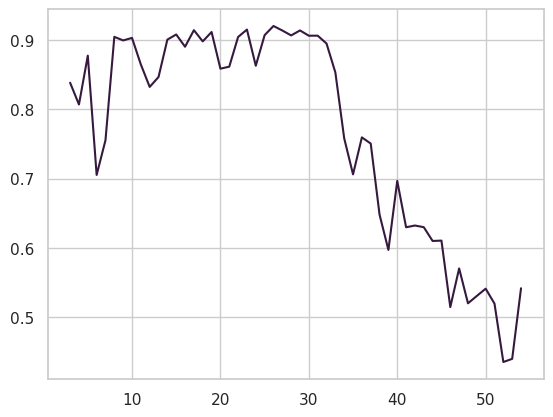

In [110]:
sns.lineplot(x = track_614.t, y = track_614.eccentricity)


In [120]:
{track.ID:[calc_eccentricity(track.properties['major_axis_length'][i],
                                  track.properties['minor_axis_length'][i]) 
                          for i in range(len(track))] for track in tracks}

{311: [0.6300866302875615,
  0.7772141243127223,
  0.5996038527990056,
  0.5481143158360369,
  0.5198633838094081,
  0.5347450717485774,
  0.21983904743332,
  0.44415173272941383,
  0.7125415429991605,
  0.6456439496170167,
  0.49657381864220485,
  0.3329687842970632,
  0.4819075692140923,
  0.39543743756385435,
  0.6242300344453278,
  0.6631127260316536,
  0.7222973715238091,
  0.6385584815152091,
  0.7396355826481461,
  0.5271322097364539,
  0.6047247704165576,
  0.69169739601209,
  0.7532842596102072,
  0.7411897361740322,
  0.649613623612003,
  0.7591705479147703,
  0.8151502460762237,
  0.8130909356294083,
  0.8136881247354553,
  0.845898888051415,
  0.8174729652045335,
  0.8498227133697926,
  0.8007640523785223,
  0.7046709633270642,
  nan,
  nan,
  nan,
  0.8023177503842017,
  0.8894120297571312,
  0.7055824382412522,
  nan,
  0.6124924299294646,
  0.8533648637851847,
  0.8479409278631855,
  0.48678359201314836,
  nan,
  0.45541108615362086,
  nan,
  0.8254699061369005,
  0.5707

In [126]:
eccentricity = pd.DataFrame.from_dict({track.ID:[calc_eccentricity(track.properties['major_axis_length'][i],
                                  track.properties['minor_axis_length'][i]) 
                          for i in range(len(track))] for track in tracks}, 
                           orient = 'index', 
                                     )

In [125]:
len([track.ID for track in tracks])

265

In [127]:
eccentricity

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
311,0.630087,0.777214,0.599604,0.548114,0.519863,0.534745,0.219839,0.444152,0.712542,0.645644,...,0.579060,0.611956,0.595528,0.544037,0.547411,0.509469,0.481300,0.694586,0.574261,0.180946
307,0.314881,0.689629,0.858924,0.490506,0.903786,0.887019,0.817788,0.842659,0.944315,0.856596,...,0.926897,0.918614,0.945683,0.955023,0.943374,0.955122,0.970072,0.957074,0.951177,0.973811
304,0.811731,0.864811,0.880473,0.870138,0.901029,0.901632,0.917847,0.906892,0.926218,0.923094,...,0.955552,NaN,0.944124,0.947188,0.947866,0.952837,0.956127,0.958824,0.944165,0.952074
303,0.954226,0.966488,0.920757,0.893347,0.959081,NaN,0.902570,0.904667,0.909789,0.868763,...,0.806517,0.652589,0.780175,0.755850,0.521818,0.799664,0.742991,0.772783,NaN,NaN
298,0.713919,0.843664,0.905994,0.940659,0.925581,0.871593,0.911158,0.885551,NaN,0.953111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.860625,0.759467,0.649219,0.873908,0.582374,0.903623,0.863895,0.899718,0.747051,0.878890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,0.894554,NaN,0.903391,0.920521,0.917090,0.889431,0.875113,0.863509,0.880190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2094,0.955754,NaN,0.948445,NaN,0.949063,NaN,0.941292,NaN,0.959397,0.963740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2099,0.636750,0.836720,NaN,0.622427,0.689193,0.762716,0.769239,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RangeIndex(start=0, stop=75, step=1)

<AxesSubplot:>

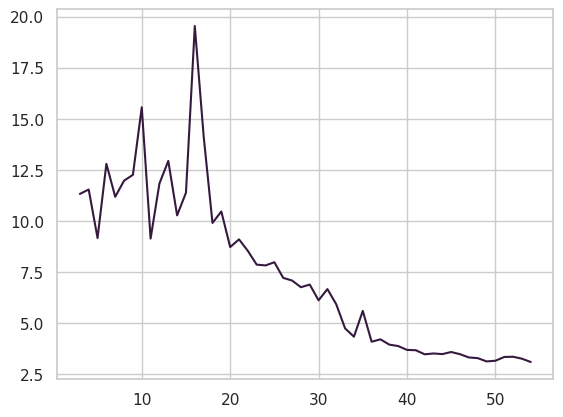

In [102]:
sns.lineplot(x = track_614.t, y = track_614.properties['mean_intensity-1']*track_614.properties['area'])


<AxesSubplot:>

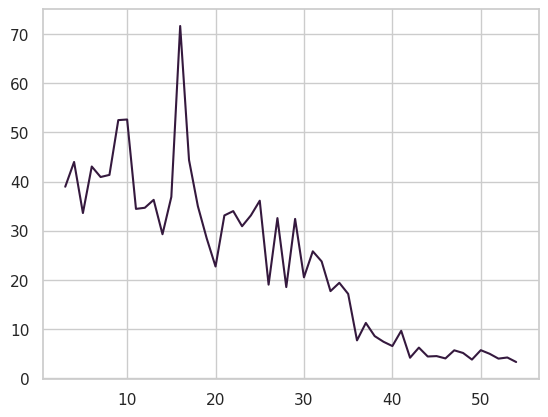

In [103]:
sns.lineplot(x = track_614.t, y = track_614.properties['mean_intensity-0']*track_614.properties['area'])

  0%|          | 0/265 [00:00<?, ?it/s]

(0.0, 1200.0, 0.0, 1200.0)

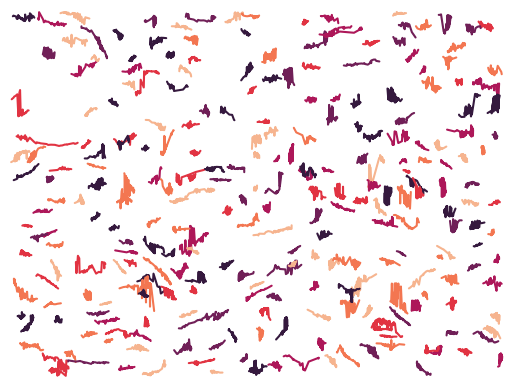

In [141]:
for track in tqdm(tracks):
    sns.lineplot(x = track.x, y = track.y)
#     sns.lineplot(x = track_614.x, y = track_614.y, color = 'green')
plt.xlim(0,1200)
plt.ylim(0,1200)
plt.axis('off')

In [144]:
pd.set_option('display.max_rows', 300)

In [379]:
len(df)

265

In [165]:
df[df['Track ID'] == '441']

,Track length,Finishing coordinates (XY),delta Area,delta Mtb load,Starting frame,Final frame,Track ID,Final Area,Est. Cell Fate
51,74,"(27, 418)",-980.0,0.000012,0,73,441,720.0,


In [166]:
track_441 = [track for track in tracks if track.ID == 441][0]

<AxesSubplot:xlabel='delta Area', ylabel='Count'>

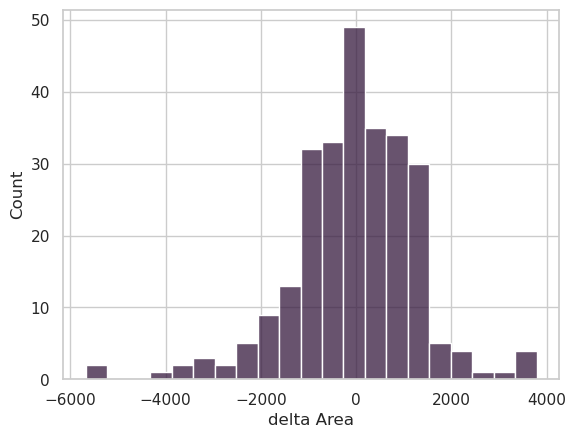

In [84]:
sns.histplot(df['delta Area'])

<AxesSubplot:xlabel='Final Area', ylabel='Count'>

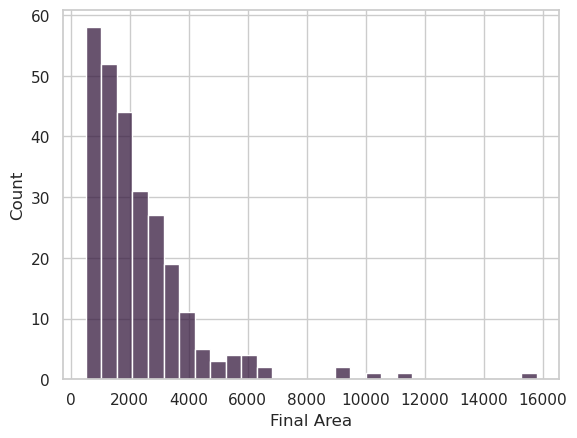

In [83]:
sns.histplot(df['Final Area'])

In [47]:
df[0:100]

,Track length,Finishing coordinates (TXY),delta Area,delta Mtb load,Starting frame,Track ID
0,75,"(74, 197, 628)",-955.0,-0.000056,0,311
1,75,"(74, 993, 33)",-482.0,-0.000119,0,307
2,75,"(74, 1189, 67)",693.0,0.000021,0,304
3,73,"(74, 133, 24)",771.0,-0.000057,0,303
4,44,"(43, 155, 68)",117.0,-0.000043,0,298
...,...,...,...,...,...,...
95,40,"(39, 639, 789)",815.0,-0.000031,0,94
96,75,"(74, 893, 793)",268.0,-0.000290,0,28
97,75,"(74, 1175, 784)",-793.0,-0.000049,0,25
98,70,"(69, 1091, 786)",3392.0,0.000154,0,22


### Manually checking cell fate

In [776]:
cell_fate = {298:'eff', 
             295:'mtb', 
             292:'lost', 
             286:'mtb', 
             285:'mtb',
             313:'lost',
             241:'lost',
             249:'lost',
             248:'lost',
             244:'mtb', 
             239:'lost', 
             281:'lost',
             280:'lost', 
             270:'lost', 
             423:'mtb',
             408:'lost',
             405:'lost',
             401:'lost',
             398:'dead', 
             448:'mtb',
             441:'mtb',
             396:'mtb',
             435:'lost', # minor
             360:'lost',
             356:'lost',
             355:'lost',
             351:'mtb',
             350:'lost',
             346:'lost',
             392:'lost',
             381:'lost',
             374:'lost',
             372:'lost',
             76:'mtb', # generous
             87:'lost',
             66:'follow', 
             107:'mtb', 
             106:'follow', 
             98:'lost', 
             96:'mtb',
             94:'lost', 
             22:'mtb',
             18:'lost', 
             15:'lost',
             12:'lost',
             49:'lost',
             193:'lost',
             173:'follow',
             217:'lost',
             213:'lost',
             212:'mtb',
             201:'lost',
             137:'lost',
             169:'lost',
             168:'follow',
             148:'lost',
             152:'lost', 
             483:'lost', #wd be difficult to track
             509:'lost',
             459:'lost',
             535:'mtb', 
             614:'mtb',
             620:'lost',
             664:'lost',
             638:'lost',
             716:'lost',
             717:'lost', 
             721:'follow', #generous
             766:'lost',
             845:'lost',
             818:'lost',
             871:'mtb',
             943:'mtb',
             916:'lost',
             914:'mtb', 
             981:'lost',
             1008:'follow',
             1014:'mtb',
             1015:'mtb',
             1061:'lost',
             1032:'lost',
             1103:'mtb',
             1091:'lost',
             1168:'mtb',
             1313:'lost',
             1400:'mtb',
             1453:'mtb',
             1455:'mtb',
             1507:'mtb',
             1604:'follow',
             1638:'follow',
             1699:'mtb', # partial follow
             1723:'follow', #partial follow
             1891:'follow', #partial follow
             2015:'lost',
             ### now the full length tracks and others that end at final frame
             311:'follow',
             307:'follow',
             304:'follow',
             303:'follow',
             293:'follow', #switches ID very early on
             337:'follow',
             335:'follow',
             334:'follow',
             328:'follow',
             327:'follow',
             323:'lost',
             321:'follow',
             317:'follow',
             253:'follow',
             246:'follow',
             232:'follow',
             230:'follow',
             228:'follow',
             279:'follow',
             278:'lost',
             273:'follow',
             267:'follow',
             266:'follow',
             419:'follow',
             418:'follow',
             417:'follow',
             416:'follow',
             413:'follow',
             406:'mtb',
             404:'follow',
             451:'follow',
             364:'follow',
             361:'follow',
             357:'follow',
             368:'follow',
             353:'follow',
             352:'follow',
             348:'follow',
             345:'follow',
             344:'follow',
             341:'follow',
             389:'follow',
             378:'follow',
             373:'lost',#generous 
             84:'lost', #stupidly generous
             83:'lost',
             74:'lost',
             68:'follow',
             67:'follow',
             63:'follow',
             113:'follow',
             111:'follow',
             104:'follow',
             103:'follow',
             58:'follow',
             28:'follow',
             25:'follow',
             48:'follow',
             194:'lost',
             227:'follow',
             116:'follow',
             203:'follow',
             140:'follow',
             138:'mtb',
             135:'follow',
             128:'follow',
             123:'follow',
             119:'follow',
             118:'follow',
             167:'follow',
             469:'follow', # generous
             558:'follow',
             596:'follow',
             642:'follow',
             643:'follow',
             769:'follow',
             798:'follow',
             809:'lost', 
             848:'follow',
             855:'dead',
             817:'follow',
             834:'follow',
             874:'follow',
             961:'follow',
             1011:'follow',
             986:'follow',
             991:'follow',
             1055:'follow',
             1030:'follow',
             1137:'follow',
             1148:'follow', # strong example of coiling
             1122:'lost', 
             1120:'follow',
             1171:'follow',
             1218:'follow',
             1199:'lost',
             1271:'follow',
             1252:'follow',
             1295:'follow',
             1297:'lost',
             1398:'eff',
             1365:'follow',
             1407:'follow',
             1406:'follow',
             1417:'follow',
             1451:'follow',
             1439:'lost',
             1498:'follow',
             1519:'follow',
             1516:'follow',
             1552:'follow',
             1554:'follow',
             1538:'lost',
             1545:'mtb',
             1607:'follow',
             1615:'follow',
             1593:'follow',
             1646:'follow',
             1657:'mtb',
             1635:'follow',
             1704:'follow',
             1700:'follow',
             1711:'follow',
             1712:'follow',
             1694:'follow',
             1679:'lost',
             1693:'lost',
             1733:'follow',
             1750:'follow',
             1761:'follow',
             1850:'follow',
             1860:'lost',
             1843:'follow',
             1896:'follow',
             1875:'follow',
             1918:'follow',
             1916:'follow',
             1906:'follow',
             1905:'follow',
             1952:'follow',
             1956:'follow',
             1961:'follow',
             1962:'follow',
             1933:'follow',
             1929:'follow',
             1992:'follow',
             1995:'follow',
             1967:'lost', ### pay attention to this point past here
             1970:'lost',
             1973:'follow',
             2024:'follow',
             2028:'follow',
             2039:'follow',
             2002:'lost',
             2008:'lost',
             2014:'lost',
             2072:'follow',
             2074:'follow',
             2053:'follow',
             2082:'follow',
             2043:'follow',
             2048:'follow',
             2094:'follow',
             2099:'follow',
             2102:'lost',
             800:'lost', 
             805:'lost',
             810:'lost',
             773:'lost',
             776:'lost',
             
             
            }

In [901]:
# visualise.clear_previous_cell_highlight(viewer = viewer)
visualise.highlight_cell(298, viewer = viewer, tracks = tracks, napari_scale=napari_scale)

<Points layer 'cell 298' at 0x7f5988e5f0a0>

In [451]:
df[df['Final frame'] == 74]

,Track length,Finishing coordinates (XY),delta Area,delta Mtb load,Starting frame,Final frame,Track ID,Final Area,Est. Cell Fate
0,75,"(197, 628)",955.0,0.000056,0,74,311,5557.0,
1,75,"(993, 33)",482.0,0.000119,0,74,307,1125.0,
2,75,"(1189, 67)",-693.0,-0.000021,0,74,304,1290.0,
3,73,"(133, 24)",-771.0,0.000057,0,74,303,930.0,
6,75,"(588, 34)",363.0,-0.001255,0,74,293,1271.0,
10,75,"(843, 44)",-407.0,0.000437,0,74,337,1947.0,
11,75,"(322, 98)",198.0,0.001345,0,74,335,1343.0,
12,75,"(665, 193)",3418.0,-0.000105,0,74,334,9219.0,
13,75,"(887, 69)",1234.0,-0.000009,0,74,328,2004.0,
14,75,"(756, 93)",769.0,0.000317,0,74,327,2082.0,


In [778]:
len(tracks)

265

In [779]:
len(cell_fate)

265

In [809]:
range(len(track))

range(0, 74)

In [1356]:
# create df for filtered tracks
df = pd.DataFrame({'Track length': [len(track) 
                                    for track in tracks],
                   'Finishing coordinates (XY)': [(int(track.x[-1]), int(track.y[-1])) 
                                                   for track in tracks], 
                   'delta Area': [track.properties['area'][-1] - track.properties['area'][0] 
                                      for track in tracks], 
                   'delta Mtb load': [track.properties['mean_intensity-1'][-1] - track.properties['mean_intensity-1'][0] 
                                          for track in tracks], 
                   'Starting frame': [track.t[0] for track in tracks],
                   'Final frame': [track.t[-1] for track in tracks], 
                   'Track ID': [f'{track.ID}' for track in tracks], 
                   'Final Area': [track.properties['area'][-1] 
                                      for track in tracks], 
                   'Cell Fate': [cell_fate[track.ID] for track in tracks], 
                   'Track Duration': [track.t for track in tracks],
                   'Track Area': [track.properties['area'] for track in tracks],
                   'Track Eccentricity': [[calc_eccentricity(track.properties['major_axis_length'][i],
                                                            track.properties['minor_axis_length'][i])
                                                            for i in range(len(track))]
                                                            for track in tracks]})

In [1358]:
df

,Track length,Finishing coordinates (XY),delta Area,delta Mtb load,Starting frame,Final frame,Track ID,Final Area,Cell Fate,Track Duration,Track Area,Track Eccentricity
0,75,"(197, 628)",955.0,0.000056,0,74,311,5557.0,follow,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[4602.0, 4329.0, 3877.0, 4449.0, 4571.0, 4631....","[0.6300866302875615, 0.7772141243127223, 0.599..."
1,75,"(993, 33)",482.0,0.000119,0,74,307,1125.0,follow,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[643.0, 851.0, 1173.0, 1508.0, 1304.0, 1461.0,...","[0.3148810775370455, 0.6896294682983573, 0.858..."
2,75,"(1189, 67)",-693.0,-0.000021,0,74,304,1290.0,follow,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1983.0, 1665.0, 1811.0, 1551.0, 1584.0, 1866....","[0.8117311371888704, 0.8648109747974894, 0.880..."
3,73,"(133, 24)",-771.0,0.000057,0,74,303,930.0,follow,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1701.0, 1305.0, 1365.0, 1019.0, 1665.0, nan, ...","[0.9542260774926564, 0.9664877786148482, 0.920..."
4,44,"(155, 68)",-117.0,0.000043,0,43,298,599.0,eff,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[716.0, 873.0, 1095.0, 1061.0, 1053.0, 920.0, ...","[0.7139192844333069, 0.8436636511669042, 0.905..."
5,64,"(332, 17)",-465.0,0.000062,0,63,295,595.0,mtb,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1060.0, 1003.0, 1119.0, 1041.0, 601.0, 891.0,...","[0.8399091321677938, 0.8404441500769071, 0.403..."
6,75,"(588, 34)",363.0,-0.001255,0,74,293,1271.0,follow,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[908.0, 889.0, 2914.0, 1808.0, 1532.0, 1748.0,...","[0.8120356589012894, 0.8412511195917691, 0.451..."
7,37,"(212, 51)",897.0,0.001833,0,36,292,1986.0,lost,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1089.0, 1070.0, 1694.0, 1696.0, 1547.0, 1983....","[0.8591417732720938, 0.9024343465314076, 0.837..."
8,67,"(1035, 91)",-1695.0,0.000059,0,67,286,657.0,mtb,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[2352.0, 2650.0, 3246.0, 1623.0, 2114.0, 3179....","[0.6674620908007846, 0.6530637885541182, 0.799..."
9,57,"(1007, 109)",-729.0,0.000056,0,57,285,618.0,mtb,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1347.0, 1437.0, 1542.0, 1267.0, 1396.0, 1091....","[0.6863385410742214, 0.7326974000839254, 0.658..."


## Plotting the fate of upper 50 cells (cells that lasted 50% of duration

In [1231]:
pal_name = 'PiYG'
palette = sns.color_palette(pal_name)
sns.color_palette(pal_name)

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [1409]:
fate_colour_dict = {'dead': palette[1], 
                    'lost':'#010137',#palette[5],
                    'follow':palette[4], 
                    'mtb':palette[0],
                    'eff': palette[2], 
                    }

fate_rename = {'dead': 'Other death',
                'lost': 'Tracking error',
                'follow':'Macrophage survival', 
                'mtb': 'Macrophage necrosis',
                'eff': 'Suspected Efferocytosis', }

In [1410]:
# Example dictionaries
dict1 = fate_rename
dict2 = cell_fate_freq

# Create a new dictionary with the same keys as dict2
fate_rename_correct_order = {key: dict1[key] for key in dict2}
fate_rename_correct_order

{'eff': 'Suspected Efferocytosis',
 'mtb': 'Macrophage necrosis',
 'lost': 'Tracking error',
 'dead': 'Other death',
 'follow': 'Macrophage survival'}

In [1286]:
correct_order_palette = [palette[2], palette[0], '#f3f3fe', palette[1], palette[4]]

In [1422]:
sum(count_values(cell_fate).values())

265

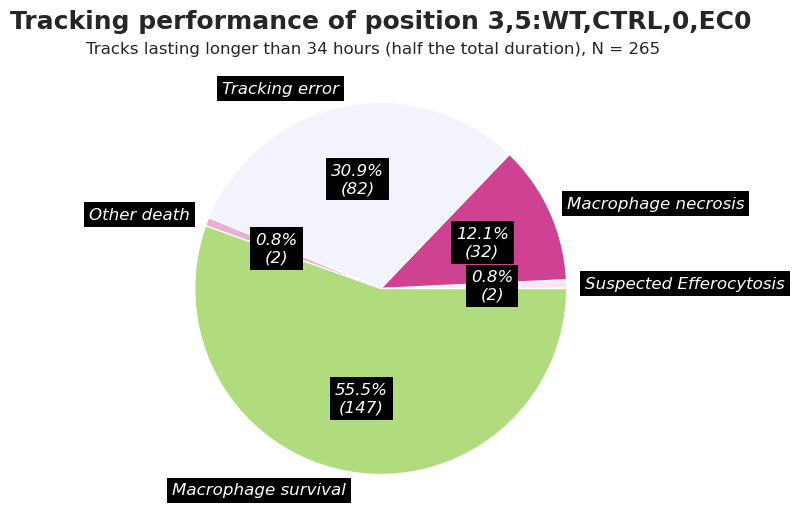

In [1442]:
bbox_props = dict(boxstyle="square,pad=0.3", fc="black", ec="black", lw=0.)
plt.pie(count_values(cell_fate).values(), 
#         labels=[f'{fate_rename_correct_order[key], cell_fate_freq[key]}' 
#                 for key in fate_rename_correct_order.keys()], 
        labels=fate_rename_correct_order.values(), 
        colors=correct_order_palette,
        autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum(count_values(cell_fate).values()))})",
       textprops={'color':'white', 
                  'style':'italic',
                  'fontsize': 12, 'bbox': bbox_props}
        )
plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', fontweight = 'bold', fontsize = 18, pad = 20)
plt.suptitle(f'Tracks lasting longer than 34 hours (half the total duration), N = {sum(count_values(cell_fate).values())}', y=0.66, fontsize=12)
plt.savefig('/mnt/DATA/macrohet/upstream_development/tracking_performance/v2_track_fate_pie_chart_3,5_manual_check.png', bbox_inches = 'tight', dpi = 324)

In [ ]:
for key in tqdm(df.keys()):
    try:
        sns.set(rc={"figure.figsize":(6, 15)}) #width=3, #height=4
        sns.set_theme(style="white")

        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)

        plot_df = df.sort_values(key, ascending=False,)
        # plot_df = df.sort_values("Track length", ascending=False,)


        for n, (i, row) in enumerate(plot_df.iterrows()):
            sns.lineplot(x = row['Track Duration'], 
                         y = [n*10 for k in range(len(row['Track Duration']))], 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 2, 
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], label=fate_rename[key]) for key in fate_colour_dict.keys()]

        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.01, 0.1)
                   )

        sns.despine(offset = 10, 
                    bottom = True, 
                    left = True
                   )
        plt.ylim(-5,len(df)*10)
        ax.set_yticklabels([])
        plt.ylabel('Single-cell track duration')
        plt.xlabel('Time (hours)')
        plt.text(x = -33, y=300, s = f'Tracks sorted by \n{key}\n(descending)', style = 'italic', fontsize = 9)
        # plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =1.025, fontweight = 'bold')
        # plt.suptitle('Tracks lasting longer than 34 hours (half the total duration)', y=0.90, fontsize=9)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =0.165, x = -0.3, fontweight = 'bold', rotation = 90, fontsize = 23)
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration)', y=0.685, x = -0.05, fontsize=16, rotation = 90)
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/track_fate_duration_plot_3,5_manual_check_sortby_{key}_horizontal.png', bbox_inches = 'tight', dpi = 324)
        plt.clf()
        
        sns.set(rc={"figure.figsize":(6, 15)}) #width=3, #height=4
        sns.set_theme(style="white")

        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)

        plot_df = df.sort_values(key, ascending=False,)
        # plot_df = df.sort_values("Track length", ascending=False,)


        for n, (i, row) in enumerate(plot_df.iterrows()):
            sns.lineplot(x = row['Track Duration'], 
                         y = [n*10 for k in range(len(row['Track Duration']))], 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 2, 
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], label=fate_rename[key]) for key in fate_colour_dict.keys()]

        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.01, 0.1)
                   )

        sns.despine(offset = 10, 
                    bottom = True, 
                    left = True
                   )
        plt.ylim(-5,len(df)*10)
        ax.set_yticklabels([])
        plt.ylabel('Single-cell track duration')
        plt.xlabel('Time (hours)')
        plt.text(x = -33, y=300, s = f'Tracks sorted by \n{key}\n(descending)', style = 'italic', fontsize = 9)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =1.025, fontweight = 'bold')
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration)', y=0.90, fontsize=9)
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/track_fate_duration_plot_3,5_manual_check_sortby_{key}_vertical.png', bbox_inches = 'tight', dpi = 324)
    except:
        print(key)

# Plot only tracks that are in the starting frame

In [1380]:
output_dir_name = ''

0

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_680458/3676918095.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1)


Track Area


<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

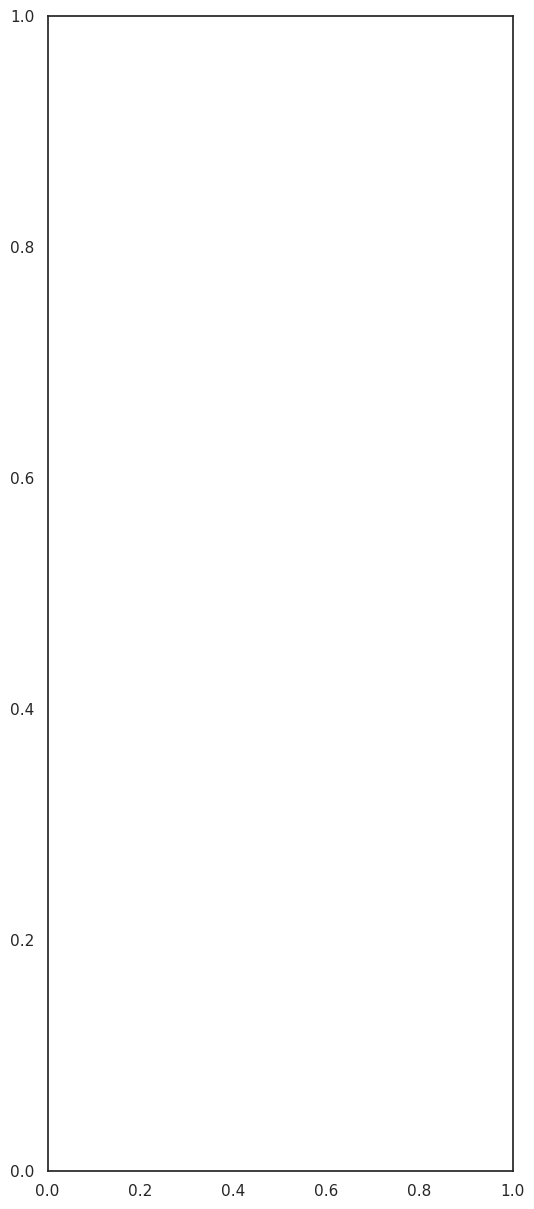

<Figure size 600x1500 with 0 Axes>

<Figure size 600x1500 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

In [1627]:
for key in tqdm(df.keys()):
    try:
        ### set dimensions for this plot (horizontal i.e. title is horizontal)
        sns.set(rc={"figure.figsize":(6, 15)}) #width=3, #height=4
        sns.set_theme(style="white")
        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)
        ### sort df by diction value
        plot_df = df.sort_values(key, ascending=False,)
        # set a counter to zero (this will enumerate each track instance)
        n2 = 0
        for n, (i, row) in enumerate(plot_df.iterrows()):
            # only include tracks that start at frame 0, this is why we need an enumeration independent of for loop
            if row['Starting frame'] != 0:
                continue
            # add to enumeration
            n2 += 1 
            # plot each track individually
            sns.lineplot(x = row['Track Duration'], 
                         y = [n2*5 for k in range(len(row['Track Duration']))], 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 4, 
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], label=fate_rename[key]) for key in fate_colour_dict.keys()]
        # plot legend
        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.01, 0.1)
                   )
        # adjust the axis so that the plot looks cleaner
        sns.despine(offset = 10, 
                    bottom = True, 
                    left = True
                   )
        #custom formatting
        plt.ylim(-5,n2*5)
        ax.set_yticklabels([])
        plt.ylabel('Single-cell track duration')
        plt.xlabel('Time (hours)')
        plt.text(x = -47, y=65, s = f'Tracks sorted by \n{key}\n(descending)', style = 'italic', fontsize = 12)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =0.165, x = -0.3, fontweight = 'bold', rotation = 90, fontsize = 23)
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.685, x = -0.05, fontsize=16, rotation = 90)
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/only_tracks_in_starting_frame/track_fate_duration_plot_3,5_manual_check_sortby_{key}_portrait_vertical_title.png', bbox_inches = 'tight', dpi = 324)
        plt.clf()
        
        # start again for vertically orientated data plot
        sns.set(rc={"figure.figsize":(6, 15)}) #width=3, #height=4
        sns.set_theme(style="white")

        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)

        plot_df = df.sort_values(key, ascending=False,)
        # plot_df = df.sort_values("Track length", ascending=False,)

        n2 = 0
        for n, (i, row) in enumerate(plot_df.iterrows()):

            if row['Starting frame'] != 0:
                continue
            n2 += 1 
            sns.lineplot(x = row['Track Duration'], 
                         y = [n2 for k in range(len(row['Track Duration']))], 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 4, 
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], label=fate_rename[key]) for key in fate_colour_dict.keys()]

        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.01, 0.1)
                   )

        sns.despine(offset = 2, 
                    bottom = True, 
                    left = True
                   )
        plt.ylim(-1,n2+1)
        ax.set_yticklabels([])
        plt.ylabel('Single-cell track duration')
        plt.xlabel('Time (hours)')
        plt.text(x = -47, y=13, s = f'Tracks sorted by \n{key}\n(descending)', style = 'italic', fontsize = 12)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =1.025, x = 0.25, fontweight = 'bold',fontsize = 18, pad = 12)
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.90, x = 0.25, fontsize=12)
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/only_tracks_in_starting_frame/track_fate_duration_plot_3,5_manual_check_sortby_{key}_portrait_horizontal_title.png', bbox_inches = 'tight', dpi = 324)
        plt.clf()
        ### now plot horizontally 
        sns.set(rc={"figure.figsize":(15, 6)})
        sns.set_theme(style="white")

        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)

        plot_df = df.sort_values(key, ascending=False,)
        # plot_df = df.sort_values("Track length", ascending=False,)

        n2 = 0
        for n, (i, row) in enumerate(plot_df.iterrows()):

            if row['Starting frame'] != 0:
                continue
            n2 += 1 

            plt.plot([n2*10 for k in range(len(row['Track Duration']))],#'y_rotated, 
                         row['Track Duration'],#x_rotated, 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 4, alpha = 1
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], 
                                      label=fate_rename[key]) 
                       for key in fate_colour_dict.keys()]

        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.05, 0.25)
                   )

        sns.despine(offset = 0, 
                    bottom = True, 
                    left = True
                   )
        # plt.xlim(-5,n2*5)
        plt.xlim(0,)
        plt.ylim(0,)
        ax.set_xticklabels([])
#         plt.xlabel('Single-cell track duration')
        plt.ylabel('Time (hours)')
        plt.text(x = -350, y=22, s = f'Tracks sorted by \n{key}\n', style = 'italic', fontsize = 12)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', 
                  y =1.06, 
                  x = 0.55, 
                  fontweight = 'bold', 
        #           rotation = 90, 
                  fontsize = 23)
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.92, x = 0.572, fontsize=16, 
        #              rotation = 90
                    )
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/only_tracks_in_starting_frame/track_fate_duration_plot_3,5_manual_check_sortby_{key}_landscape.png', bbox_inches = 'tight', dpi = 324)
        plt.clf()
        
        ## rainfall plot
        sns.set(rc={"figure.figsize":(15, 6)})
        sns.set_theme(style="white")

        # Create Figure and Axes instances
        fig,ax = plt.subplots(1)

        plot_df = df.sort_values(key, ascending=False,)
        # plot_df = df.sort_values("Track length", ascending=False,)

        n2 = 0
        for n, (i, row) in enumerate(plot_df.iterrows()):

            if row['Starting frame'] != 0:
                continue
            n2 += 1 

            plt.plot([n2*10 for k in range(len(row['Track Duration']))],#'y_rotated, 
                         row['Track Duration'],#x_rotated, 
                         color = fate_colour_dict[row['Cell Fate']], 
                         linewidth = 4, alpha = 1
                        )

        ### match custom colour keys to names and plot as legend
        custom_keys = [mpatches.Patch(color=fate_colour_dict[key], 
                                      label=fate_rename[key]) 
                       for key in fate_colour_dict.keys()]

        plt.legend(handles=custom_keys, fancybox = True, 
                                        framealpha = 0.8, 
                   bbox_to_anchor=(-0.04, 1.02)
                   )

        sns.despine(offset = 0, 
                    bottom = True, 
                    left = True
                   )
        # plt.xlim(-5,n2*5)
        plt.xlim(0,)
        plt.ylim(0,)
        ax.set_xticklabels([])
#         plt.xlabel('Single-cell track duration')
        plt.ylabel('Time (hours)')
        plt.text(x = -335, y=30, s = f'Tracks sorted by \n{key}\n', style = 'italic', fontsize = 12)
        plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', 
                  y =1.07, 
                  x = 0.55, 
                  fontweight = 'bold', 
        #           rotation = 90, 
                  fontsize = 23)
        plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.93, x = 0.572, fontsize=16, 
        #              rotation = 90
                    )
        plt.gca().invert_yaxis()
        plt.savefig(f'/mnt/DATA/macrohet/upstream_development/tracking_performance/only_tracks_in_starting_frame/track_fate_duration_plot_3,5_manual_check_sortby_{key}_landscape_rainfall.png', bbox_inches = 'tight', dpi = 324)
        plt.clf()
    except:
        print(key)

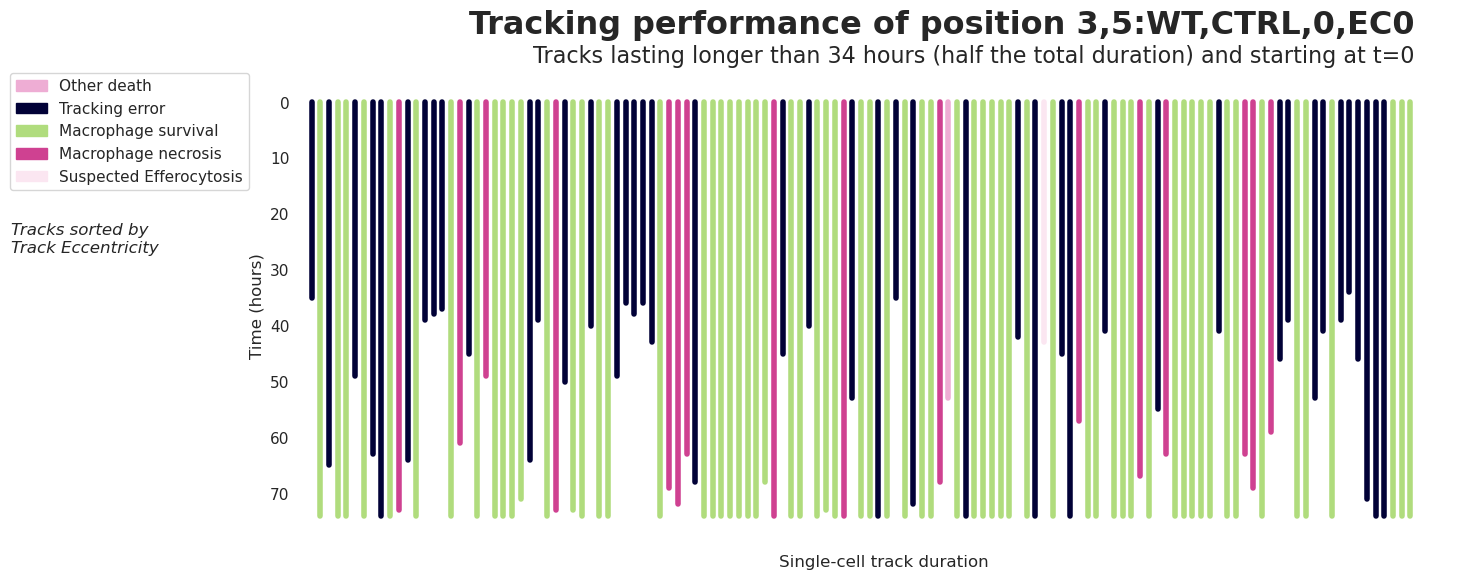

In [1628]:
sns.set(rc={"figure.figsize":(15, 6)})
sns.set_theme(style="white")

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

plot_df = df.sort_values(key, ascending=False,)
# plot_df = df.sort_values("Track length", ascending=False,)

n2 = 0
for n, (i, row) in enumerate(plot_df.iterrows()):

    if row['Starting frame'] != 0:
        continue
    n2 += 1 
    
    plt.plot([n2*10 for k in range(len(row['Track Duration']))],#'y_rotated, 
                 row['Track Duration'],#x_rotated, 
                 color = fate_colour_dict[row['Cell Fate']], 
                 linewidth = 4, alpha = 1
                )

### match custom colour keys to names and plot as legend
custom_keys = [mpatches.Patch(color=fate_colour_dict[key], 
                              label=fate_rename[key]) 
               for key in fate_colour_dict.keys()]

plt.legend(handles=custom_keys, fancybox = True, 
                                framealpha = 0.8, 
           bbox_to_anchor=(-0.04, 1.02)
           )

sns.despine(offset = 0, 
            bottom = True, 
            left = True
           )
# plt.xlim(-5,n2*5)
plt.xlim(0,)
plt.ylim(-5,)
ax.set_xticklabels([])
plt.xlabel('Single-cell track duration')
plt.ylabel('Time (hours)')
plt.text(x = -335, y=30, s = f'Tracks sorted by \n{key}\n', style = 'italic', fontsize = 12)
plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', 
          y =1.07, 
          x = 0.55, 
          fontweight = 'bold', 
#           rotation = 90, 
          fontsize = 23)
plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.93, x = 0.572, fontsize=16, 
#              rotation = 90
            )
plt.gca().invert_yaxis()


Text(0.25, 0.9, 'Tracks lasting longer than 34 hours (half the total duration) and starting at t=0')

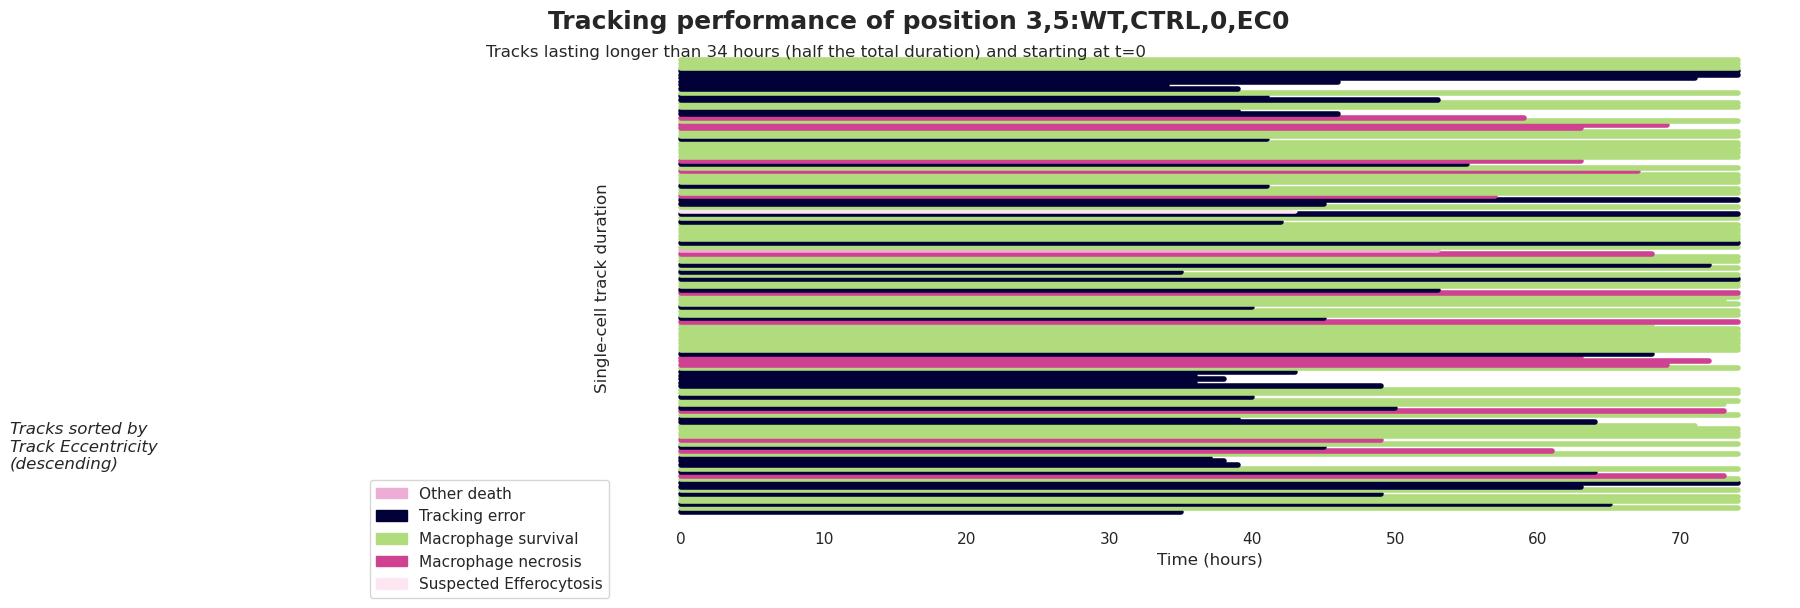

In [1626]:
 # Create Figure and Axes instances
fig,ax = plt.subplots(1)

plot_df = df.sort_values(key, ascending=False,)
# plot_df = df.sort_values("Track length", ascending=False,)

n2 = 0
for n, (i, row) in enumerate(plot_df.iterrows()):

    if row['Starting frame'] != 0:
        continue
    n2 += 1 
    sns.lineplot(x = row['Track Duration'], 
                 y = [n2 for k in range(len(row['Track Duration']))], 
                 color = fate_colour_dict[row['Cell Fate']], 
                 linewidth = 4, 
                )

### match custom colour keys to names and plot as legend
custom_keys = [mpatches.Patch(color=fate_colour_dict[key], label=fate_rename[key]) for key in fate_colour_dict.keys()]

plt.legend(handles=custom_keys, fancybox = True, 
                                framealpha = 0.8, 
           bbox_to_anchor=(-0.01, 0.1)
           )

sns.despine(offset = 2, 
            bottom = True, 
            left = True
           )
plt.ylim(-1,n2+1)
ax.set_yticklabels([])
plt.ylabel('Single-cell track duration')
plt.xlabel('Time (hours)')
plt.text(x = -47, y=13, s = f'Tracks sorted by \n{key}\n(descending)', style = 'italic', fontsize = 12)
plt.title('Tracking performance of position 3,5:WT,CTRL,0,EC0', y =1.025, x = 0.25, fontweight = 'bold',fontsize = 18, pad = 12)
plt.suptitle('Tracks lasting longer than 34 hours (half the total duration) and starting at t=0', y=0.90, x = 0.25, fontsize=12)
